# Biodiversity Intactness Index Change in Phoenix, AZ

Author: Matteo Torres

Repository: https://github.com/matteo-torres/bii-project

### Purpose
This study aims to investigate the effects of urban expansion by analyzing the Biodiversity Intactness Index (BII). In this notebook, we examine changes in BII within the Phoenix County subdivision area from 2017 to 2020, highlighting how urban growth impacts biodiversity over time.

### Highlights
- Accessing data using the SpatioTemporal Asset Catalog (STAC)
- Clipping raster data to the geometry of a shapefile
- Land cover statistics

### About the Data
The US Census Bureau's TIGER/Line shapefile for Arizona provides geographic boundaries for each county and its subdivisions. These shapefiles include polygon boundaries for legal and statistical entities, as well as linear features like roads and waterways, and point features. This comprehensive dataset represents the current geographic extent of various geographic areas and features in the state.

The Biodiversity Intactness dataset, available in the Microsoft Planetary Computer STAC catalog, is derived from two key metrics: Abundance, which measures the number of individual species, and Compositional Similarity, which assesses how closely the species composition resembles an undisturbed baseline. This dataset provides insights into terrestrial biodiversity intactness at a resolution of 100 meters.

### References
2020 tiger/line® shapefiles: County+subdivisions. United States Census Bureau. (n.d.). https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County%2BSubdivisions  

Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/io-biodiversity 

### Load Libraries

In [1]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr

import pystac_client
import planetary_computer
from IPython.display import Image 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

### Filter Phoenix, AZ Polygon

<Axes: >

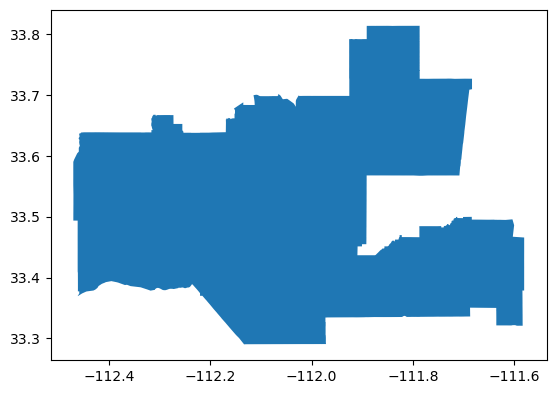

In [2]:
# Create a reproducible file path
fp = os.path.join("data", "tl_2020_04_cousub", "tl_2020_04_cousub.shp")

# Import and read Arizona shapefile
arizona = gpd.read_file(fp)

# Filter Phoenix polygon
phoenix = arizona[arizona["NAME"] == "Phoenix"]

# Plot Phoenix polygon
phoenix.plot()

### Visualize BII Changes in Phoenix, AZ

In [3]:
# Access MPC Catalog
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace)

# Bounding box of Phoenix, AZ
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Catalog search
search = catalog.search(collections = ["io-biodiversity"],
                        bbox = bbox_of_interest,
                        datetime = time_range)

# Retrieve search items
items = search.item_collection()

# Verify
items

### Data Exploration

In [4]:
# Assign 2017 and 2020 items
item_17 = items[3]
item_20 = items[0]

# Print their asset key and title
for key in items[0].assets.keys():
    print(key, "--", items[0].assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [5]:
# Plot the 2017 rendered preview
Image(url = item_17.assets["rendered_preview"].href, width = 500)

In [6]:
# Plot the 2020 rendered preview
Image(url = item_20.assets["rendered_preview"].href, width = 500)

In [7]:
# Access the rasters from the data asset
raster_17 = rioxr.open_rasterio(item_17.assets["data"].href)
raster_20 = rioxr.open_rasterio(item_20.assets["data"].href)

# Explore rasters
print(raster_17)
print(raster_20)

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


### Data Processing

In [8]:
# Remove the length 1 dimension (band)
raster_17 = raster_17.squeeze().drop_vars("band")
raster_20 = raster_20.squeeze().drop_vars("band")

# Verify dimensions
print("Sizes of raster_17 dimensions:", dict(raster_17.sizes))
print("Sizes of raster_20 dimensions:", dict(raster_20.sizes))

Sizes of raster_17 dimensions: {'y': 7992, 'x': 7992}
Sizes of raster_20 dimensions: {'y': 7992, 'x': 7992}


In [9]:
# Check for matching coordinate reference systems
print(f"item_17 CRS: EPSG:{item_17.properties['proj:epsg']}")
print(f"item_20 CRS: EPSG:{item_20.properties['proj:epsg']}")
print(f"phoenix CRS: {phoenix.crs}")

item_17 CRS: EPSG:4326
item_20 CRS: EPSG:4326
phoenix CRS: EPSG:4269


In [10]:
# Reproject phoenix shapefile crs
phoenix = phoenix.to_crs(epsg = 4326)

# Verify change
print(f"phoenix CRS: {phoenix.crs}")

phoenix CRS: EPSG:4326


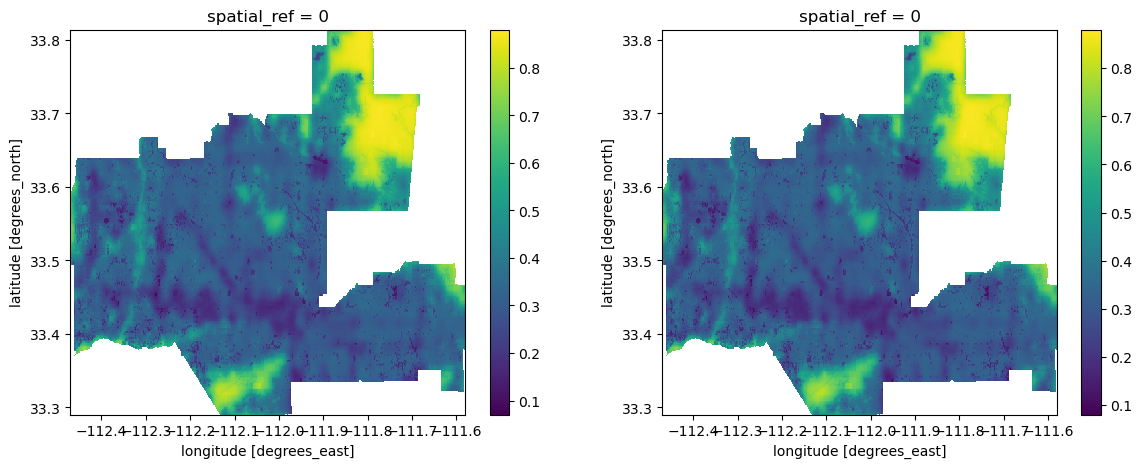

In [11]:
# Clip rasters to the phoenix total bounds and exact geometry
clip_17 = (raster_17.rio.clip_box(*phoenix.total_bounds)
           .rio.clip(phoenix.geometry))

clip_20 = (raster_20.rio.clip_box(*phoenix.total_bounds)
           .rio.clip(phoenix.geometry))

# Plot clipped rasters
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

clip_17.plot(ax = ax[0])
clip_20.plot(ax = ax[1])

plt.show()

### Data Analysis

In [12]:
# Create a function to calculate the percentage of area with BII >= 0.75
def calculate_percentage_bii(raster):
    bii_mask = raster >= 0.75
    bii_area = bii_mask.sum()
    total_area = bii_mask.size
    percentage = (bii_area / total_area) * 100
    return percentage

# Calculate percentage for both years
percentage_17 = calculate_percentage_bii(clip_17)
percentage_20 = calculate_percentage_bii(clip_20)

# Print percentages
print(f"Percentage of Phoenix area with BII >= 0.75 in 2017: {percentage_17:.2f}%")
print(f"Percentage of Phoenix area with BII >= 0.75 in 2020: {percentage_20:.2f}%")

Percentage of Phoenix area with BII >= 0.75 in 2017: 4.18%
Percentage of Phoenix area with BII >= 0.75 in 2020: 3.81%


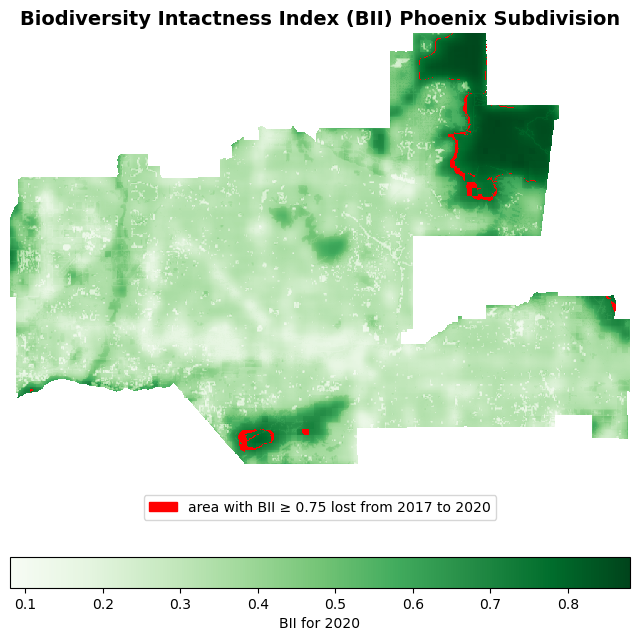

In [13]:
# Plot the area with BII >= 0.75 in 2017 that was lost by 2020
fig, ax = plt.subplots(figsize = (8, 8))

clip_20.plot(ax = ax, 
             cmap = "Greens",
             cbar_kwargs = {"orientation": "horizontal", 
                            "label": "BII for 2020"})

# Create a Boolean mask indicating areas
bii_diff = (clip_17 >= 0.75) & (clip_20 < 0.75)

bii_diff.plot(ax= ax, 
              cmap = ListedColormap(["none", "red"]), 
              add_colorbar = False)

# Add a legend for BII difference
legend_patch = Patch(color = "red", 
                     label = "area with BII ≥ 0.75 lost from 2017 to 2020")

ax.legend(handles = [legend_patch], 
          loc = "center", 
          bbox_to_anchor = (0.5, -0.1), 
          ncol = 1)

# Add a title
ax.set_title("Biodiversity Intactness Index (BII) Phoenix Subdivision", 
             fontweight="bold", 
             fontsize=14)

# Remove axes
ax.axis("off")

plt.show()

**Description**

The results indicate a decrease in Biodiversity Intactness Index (BII) areas with percentages of 0.75 or higher from 2017 to 2020. The plot illustrates the biodiversity areas lost due to urban expansion in Phoenix, AZ. As shown in the plot, the areas most affected are those with higher BII, which are represented by the darker green.